In [1]:
%%capture

!pip install roboflow
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git >> /tmp/null

import os
import gc
import h5py
import time
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import cv2
from enum import auto, Enum
from datetime import datetime
from functools import partial
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import Metric
from tensorflow.python.framework.ops import EagerTensor
import tensorflow.keras.backend as K
from keras.layers import Layer, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Concatenate

from PIL import Image

from roboflow import Roboflow

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Libreria GCPDS
from gcpds.image_segmentation.datasets.segmentation import OxfordIiitPet
from gcpds.image_segmentation.visualizations import plot_contour
from gcpds.image_segmentation.models import unet_baseline

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.style import available

# Warnings
import warnings

# Custom activation function
from keras.layers import Activation

from glob import glob

import shutil

## Retrieve dataset

In [2]:
rf = Roboflow(api_key="3ioUIbqERJ2jEWElELQN")
project = rf.workspace("gcpds-tm2ae").project("seed-detection-2")
dataset = project.version(1).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...


## Conversión del dataset a tensores

In [5]:
def decode_img(img, target_size):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, target_size) / 255.0

def decode_mask(mask, target_size):
    mask = tf.image.decode_png(mask, channels=1)
    return tf.image.resize(mask, target_size) / 255.0

def process_path(image_path, mask_path, target_size):
    img = tf.io.read_file(image_path)
    img = decode_img(img, target_size)
    mask = tf.io.read_file(mask_path)
    mask = decode_mask(mask, target_size)
    return img, mask

def load_dataset(data_dir, target_size, batch_size):
    image_files = [f for f in os.listdir(data_dir) if f.endswith(".jpg")]
    image_paths = [os.path.join(data_dir, img_file) for img_file in image_files]
    mask_paths = [path.replace(".jpg", "_mask.png") for path in image_paths]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: process_path(x, y, target_size),
                          num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset


In [6]:
start_time = time.time()
dataset_train = load_dataset(data_dir="./Seed-Detection-2-1/train", target_size=(256,256), batch_size=32)
dataset_test = load_dataset(data_dir="./Seed-Detection-2-1/test", target_size=(256,256), batch_size=32)
dataset_valid = load_dataset(data_dir="./Seed-Detection-2-1/valid", target_size=(256,256), batch_size=32)
elapsed_time = time.time() - start_time
print(f"El tiempo de ejecución de la conversión del dataset a tensores fue de {elapsed_time:.3f} segundos.")

El tiempo de ejecución de la conversión del dataset a tensores fue de 0.411 segundos.


### Train data

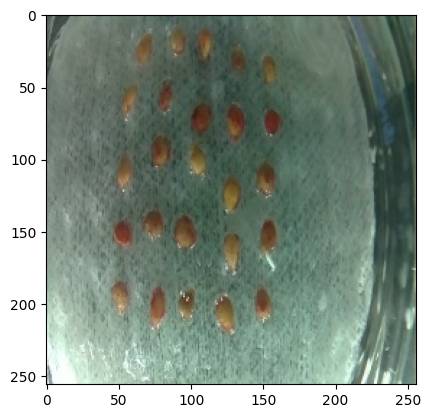

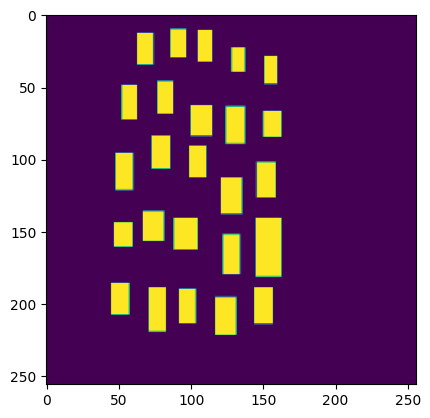

In [7]:
for img, mask in dataset_train.take(1):
  plt.imshow(img[0])
  plt.show()
  plt.imshow(mask[0])
  plt.show()


## Train segmentation UNet

In [8]:
@keras.saving.register_keras_serializable(package="MyLayers")
class DiceCoefficient(Loss):
    def __init__(self, smooth=1., target_class= None, name='DiceCoefficient', **kwargs):
        self.smooth = smooth
        self.target_class = target_class
        super().__init__(name=name,**kwargs)

    def call(self, y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=[1,2])
        union = K.sum(y_true,axis=[1,2]) + K.sum(y_pred,axis=[1,2])
        dice_coef = -(2. * intersection + self.smooth) /(union + self.smooth)

        if self.target_class != None:
            dice_coef = tf.gather(dice_coef,
                                  self.target_class, axis=1)
        else:
            dice_coef = K.mean(dice_coef,axis=-1)

        return dice_coef

    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "smooth": self.smooth,
                "target_class":self.target_class}

In [9]:
TARGET_SHAPE = (256,256)
NUM_EPOCHS = 50

model = unet_baseline(input_shape= TARGET_SHAPE + (3,), out_channels=1)
model.compile(
    loss=DiceCoefficient(),
    optimizer="adam",
    )
model.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x788e01942470>>

In [10]:
model.fit(
    dataset_train,
    validation_data=dataset_valid,
    epochs=NUM_EPOCHS
)

Epoch 1/50
68/68 [==============================] - 23s 110ms/step - loss: -0.3695 - val_loss: -0.0621
Epoch 2/50
68/68 [==============================] - 5s 69ms/step - loss: -0.5139 - val_loss: -0.0443
Epoch 3/50
68/68 [==============================] - 5s 69ms/step - loss: -0.6024 - val_loss: -0.2989
Epoch 4/50
68/68 [==============================] - 5s 69ms/step - loss: -0.6779 - val_loss: -0.6745
Epoch 5/50
68/68 [==============================] - 5s 69ms/step - loss: -0.7375 - val_loss: -0.8166
Epoch 6/50
68/68 [==============================] - 5s 70ms/step - loss: -0.7970 - val_loss: -0.8493
Epoch 7/50
68/68 [==============================] - 5s 70ms/step - loss: -0.8289 - val_loss: -0.8682
Epoch 8/50
68/68 [==============================] - 5s 70ms/step - loss: -0.8488 - val_loss: -0.8799
Epoch 9/50
68/68 [==============================] - 5s 70ms/step - loss: -0.8633 - val_loss: -0.8929
Epoch 10/50
68/68 [==============================] - 5s 69ms/step - loss: -0.8739 - val_l

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
destination_path = "/content/drive/MyDrive/models/Tomato Seeds"

model_save_path = os.path.join(destination_path ,"tomato_seed_base_model.keras")
model.save(filepath=model_save_path)
model_save_path

'/content/drive/MyDrive/models/Tomato Seeds/tomato_seed_base_model.keras'